In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as T

import os
import wandb
import math
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

EMAIL_USERNAME = "reddy.bathula"

In [8]:

F_MNIST_MEAN = (0.2860,)
F_MNIST_STD = (0.3530,)

class FashionMNISTDataset(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform
        self.to_tensor = T.ToTensor()

    def __len__(self):
        """Returns the length of the dataset."""
        return len(self.base_dataset)

    def __getitem__(self, idx):
        """Returns the image, class label, and ink target for the given index."""
        pil_image, class_label = self.base_dataset[idx]
        image_tensor = self.to_tensor(pil_image)
        ink_target = torch.mean(image_tensor)
        if self.transform:
            image_tensor = self.transform(image_tensor)
        return image_tensor, class_label, ink_target

def load_fashion_data(batch_size=64, val_split=0.1):
    """ Loads and prepares the Fashion-MNIST dataset for the multi-task experiment. """
    
    train_transform = T.Compose([T.RandomAffine(degrees=10, translate=(0.1, 0.1)), T.Normalize(F_MNIST_MEAN, F_MNIST_STD)])
    val_test_transform = T.Compose([T.Normalize(F_MNIST_MEAN, F_MNIST_STD)])
    full_train_set_raw = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

    train_size = int((1.0 - val_split) * len(full_train_set_raw))
    val_size = len(full_train_set_raw) - train_size
    train_data_raw, val_data_raw = random_split(full_train_set_raw, [train_size, val_size], generator=torch.Generator().manual_seed(42)) # for reproducibility
    test_set_raw = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)
    train_dataset = FashionMNISTDataset(train_data_raw, transform=train_transform)
    val_dataset = FashionMNISTDataset(val_data_raw, transform=val_test_transform)
    test_dataset = FashionMNISTDataset(test_set_raw, transform=val_test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader


In [9]:
class MultiTaskCNN(nn.Module):
    """
    Implements a  modular multi-task CNN for Fashion-MNIST.
    All key architecture hyperparameters are passed externally, including separate hidden dimensions for each head.
    """
    
    def __init__(self, 
                 num_blocks=2, 
                 base_filters=32, 
                 class_hidden_dim=128, 
                 reg_hidden_dim=128,  
                 dropout_rate=0.2,
                 conv_kernel_size=3,
                 pool_kernel_size=2,
                 pool_stride=2):
        """ Defines the model architecture dynamically based on passed hyperparameters."""
        super(MultiTaskCNN, self).__init__()

        assert num_blocks in [2, 3]
        self.backbone_layers = nn.ModuleList()
        in_channels = 1 
        conv_padding = (conv_kernel_size - 1) // 2
        
        for i in range(num_blocks):
            out_channels = base_filters * (2**i)
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=conv_kernel_size, padding=conv_padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
            )
            self.backbone_layers.append(block)
            in_channels = out_channels
            
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            for block in self.backbone_layers:
                x = block(x)
            final_shape = x.shape
            self.final_flat_features = final_shape[1] * final_shape[2] * final_shape[3]            
        self.flatten = nn.Flatten()
        
        self.classification_head = nn.Sequential(
            nn.Linear(self.final_flat_features, class_hidden_dim), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(class_hidden_dim, 10)
        )
        
        self.regression_head = nn.Sequential(
            nn.Linear(self.final_flat_features, reg_hidden_dim), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(reg_hidden_dim, 1)
        )

    def forward(self, x, return_features=False):
        """ The forward pass. """
        feature_maps = []
        
        for block in self.backbone_layers:
            x = block(x)
            if return_features:
                feature_maps.append(x)
                
        flat_features = self.flatten(x)
        logits_class = self.classification_head(flat_features)
        value_ink = self.regression_head(flat_features)
        
        if return_features:
            return logits_class, value_ink, feature_maps
        else:
            return logits_class, value_ink

In [ ]:
class ExperimentManager:
    """ Manages the full lifecycle of training, validation, logging, and visualization."""
    
    def __init__(self, experiments_dict, email_username, wandb_project="MissedNameHere"):
        """ Initializes the manager. """
        self.experiments = experiments_dict
        self.email_username = email_username
        self.wandb_project = wandb_project
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        os.makedirs(f"./models/{wandb_project}", exist_ok=True)
        print(f"ExperimentManager initialized. Using device: {self.device}")

    
    def run_all_experiments(self):
        """ Iterates through all experiments, trains, and logs them to wandb. """
        print("--- Starting all wandb Experiments ---")
        for run_name, config in self.experiments.items():
            print(f"\n--- Starting Run: {run_name} ---")
            self._train_one_experiment(config, run_name)
        print("\n--- All experiments completed. ---")

    def visualize_model(self, run_name, num_images=3):
        """
        Visualizes the feature maps for a specified, trained model.
        It loads the model corresponding to 'best_acc_{run_name}.pth'.
        """
        print(f"\n--- Starting Feature Map Visualization for '{run_name}' ---")
        vis_model_config = self.experiments.get(run_name)
        if vis_model_config is None:
            print(f"ERROR: Run name '{run_name}' not found in experiments dict.")
            return

        model_args = self._filter_config_for_model(vis_model_config)
        vis_model = MultiTaskCNN(**model_args).to(self.device)
        model_path = f"./models/best_acc_{run_name}.pth"
        if not os.path.exists(model_path):
            print(f"ERROR: Model file not found at {model_path}.")
            print("Please run training first.")
            return

        vis_model.load_state_dict(torch.load(model_path, map_location=self.device))
        _, _, test_loader = load_fashion_data(batch_size=num_images)
        self._visualize_feature_maps(vis_model, test_loader, num_images)

    def _train_one_experiment(self, config, run_name):
        """
        Runs a complete training and validation experiment based on a config dict.
        Logs all results to Weights & Biases.
        """
        run = wandb.init(
            project=self.wandb_project,
            config=config,
            name=run_name
        )
        
        train_loader, val_loader, _ = load_fashion_data(batch_size=config['batch_size'])
        model_args = self._filter_config_for_model(config)
        model = MultiTaskCNN(**model_args).to(self.device)
        
        if config['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        elif config['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
        elif config['optimizer'] == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])
        
        criterion_class = nn.CrossEntropyLoss()
        criterion_reg = nn.MSELoss()
        
        lambda1 = config['lambda1']
        lambda2 = config['lambda2']

        best_val_acc = 0.0
        best_val_rmse = float('inf')
        
        for epoch in range(config['epochs']):
            model.train()
            train_loss_total, train_loss_ce, train_loss_mse = 0, 0, 0
            
            for images, labels, inks in tqdm(train_loader, desc=f"Epoch {epoch+1} Train"):
                images, labels, inks = images.to(self.device), labels.to(self.device), inks.to(self.device).float().squeeze()
                
                optimizer.zero_grad()
                logits_class, value_ink = model(images)
                value_ink = value_ink.squeeze()

                loss_class = criterion_class(logits_class, labels)
                loss_reg = criterion_reg(value_ink.squeeze(), inks)
                
                total_loss = (lambda1 * loss_class) + (lambda2 * loss_reg)
                total_loss.backward()
                optimizer.step()
                
                train_loss_total += total_loss.item()
                train_loss_ce += loss_class.item()
                train_loss_mse += loss_reg.item()
                
            wandb.log({
                "epoch": epoch,
                "train_loss_total": train_loss_total / len(train_loader),
                "train_loss_ce": train_loss_ce / len(train_loader),
                "train_loss_mse": train_loss_mse / len(train_loader),
            })

            model.eval()
            val_loss_total, val_loss_ce, val_loss_mse = 0, 0, 0
            all_preds_class, all_labels_class = [], []
            all_preds_reg, all_labels_reg = [], []
            
            with torch.no_grad():
                for images, labels, inks in tqdm(val_loader, desc=f"Epoch {epoch+1} Val"):
                    images, labels, inks = images.to(self.device), labels.to(self.device), inks.to(self.device).float().squeeze()
                    
                    logits_class, value_ink = model(images)
                    
                    loss_class = criterion_class(logits_class, labels)
                    loss_reg = criterion_reg(value_ink.squeeze(), inks)
                    total_loss = (lambda1 * loss_class) + (lambda2 * loss_reg)
                    
                    val_loss_total += total_loss.item()
                    val_loss_ce += loss_class.item()
                    val_loss_mse += loss_reg.item()
                    
                    all_preds_class.append(logits_class.cpu())
                    all_labels_class.append(labels.cpu())
                    all_preds_reg.append(value_ink.cpu())
                    all_labels_reg.append(inks.cpu())

            all_preds_class = torch.cat(all_preds_class)
            all_labels_class = torch.cat(all_labels_class)
            all_preds_reg = torch.cat(all_preds_reg).squeeze()
            all_labels_reg = torch.cat(all_labels_reg)

            val_acc = self._calculate_accuracy(all_preds_class, all_labels_class)
            val_mae = self._calculate_mae(all_preds_reg, all_labels_reg)
            val_rmse = self._calculate_rmse(all_preds_reg, all_labels_reg)
            
            wandb.log({
                "epoch": epoch,
                "val_loss_total": val_loss_total / len(val_loader),
                "val_loss_ce": val_loss_ce / len(val_loader),
                "val_loss_mse": val_loss_mse / len(val_loader),
                "val_accuracy": val_acc,
                "val_mae": val_mae,
                "val_rmse": val_rmse,
            })
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f"./models/best_acc_{run.name}.pth")
                wandb.summary['best_val_accuracy'] = best_val_acc

            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                torch.save(model.state_dict(), f"./models/best_rmse_{run.name}.pth")
                wandb.summary['best_val_rmse'] = best_val_rmse
        
        print(f"Finished run: {run.name}")
        run.finish()

    def _visualize_feature_maps(self, model, data_loader, num_images=3, num_channels_to_plot=8):
        """ Visualizes the original image, and then a grid of 8 individual feature maps from each convolutional block. """
        model.eval()
        images, _, _ = next(iter(data_loader))
        images_to_plot = images[:num_images].to(self.device)
        with torch.no_grad():
            _, _, feature_maps = model(images_to_plot, return_features=True)
        for img_idx in range(num_images):
            img = images_to_plot[img_idx].cpu().numpy().squeeze()
            img = (img * F_MNIST_STD[0]) + F_MNIST_MEAN[0]
            plt.figure(figsize=(4, 4))
            plt.title(f"Original Image #{img_idx+1}")
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.text(
                0.95, 0.05, self.email_username, ha='right', va='bottom',
                transform=plt.gca().transAxes,
                fontsize=10, color='gray', alpha=0.7
            )
            plt.show()

            for block_idx, f_map in enumerate(feature_maps):
                f_map_img = f_map[img_idx].cpu()
                num_channels = min(f_map_img.shape[0], num_channels_to_plot)
                fig, axes = plt.subplots(
                    1, 
                    num_channels, 
                    figsize=(num_channels * 4, 4) 
                )
      
                if num_channels == 1:
                    axes = [axes]
                    
                fig_title = f"Block {block_idx+1} Feature Maps (First {num_channels}) - Img {img_idx+1}"
                fig.suptitle(fig_title, fontsize=16)

                for i in range(num_channels):
                    ax = axes[i]
                    im = ax.imshow(f_map_img[i], cmap='viridis')
                    ax.set_title(f"Channel {i}")
                    ax.set_xticks([])
                    ax.set_yticks([])
                    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

                for i in range(num_channels, len(axes)):
                    axes[i].set_visible(False)
                plt.text(
                    0.95, 0.01, self.email_username, ha='right', va='bottom',
                    transform=fig.transFigure,
                    fontsize=10, color='gray', alpha=0.7
                )
                plt.show()
    
    @staticmethod
    def _calculate_accuracy(preds, targets):
        """Calculates classification accuracy."""
        pred_labels = torch.argmax(preds, dim=1)
        return (pred_labels == targets).float().mean().item()

    @staticmethod
    def _calculate_mae(preds, targets):
        """Calculates Mean Absolute Error (MAE)."""
        return F.l1_loss(preds, targets).item()

    @staticmethod
    def _calculate_rmse(preds, targets):
        """Calculates Root Mean Squared Error (RMSE)."""
        mse = F.mse_loss(preds, targets).item()
        return math.sqrt(mse)

    @staticmethod
    def _filter_config_for_model(config):
        """ Selects only the keys from the config dict that are valid arguments for the MultiTaskCNN __init__ method. """
        model_arg_keys = {
            'num_blocks', 'base_filters', 'class_hidden_dim', 'reg_hidden_dim',
            'dropout_rate', 'conv_kernel_size', 'pool_kernel_size', 'pool_stride'
        }
        model_config = {k: config[k] for k in config if k in model_arg_keys}
        return model_config

In [11]:
class WandBAnalyzer:
    """
    A comprehensive class for analyzing, comparing, and visualizing W&B experiment results.
    Handles data extraction, table generation, Excel export, and best model identification.
    """
    
    def __init__(self, experiment_projects):
        """ Initialize the analyzer with W&B project names. """
        self.projects = experiment_projects
        self.api = wandb.Api()
        self.all_tables = {}
        
    def create_experiment_table(self, project_name, include_all_metrics=True):
        """ Fetches all runs from a W&B project and creates a comparison DataFrame. """
        runs = self.api.runs(f"{self.api.default_entity}/{project_name}")
        data_list = []
        
        for run in runs:
            row = {'Run Name': run.name}
            row.update(self._extract_config(run))
            row.update(self._extract_metrics(run, include_all_metrics))
            data_list.append(row)
        return pd.DataFrame(data_list)
    
    def _extract_config(self, run):
        """Extract configuration from a W&B run."""
        config_data = {}
        try:
            config_json = json.loads(run.config)
            for key, value_dict in config_json.items():
                if key.startswith('_'):
                    continue
                if isinstance(value_dict, dict) and 'value' in value_dict:
                    config_data[key] = value_dict['value']
                else:
                    config_data[key] = value_dict
        except Exception as e:
            print(f"Config error for {run.name}: {e}")
        
        return config_data
    
    def _extract_metrics(self, run, include_all_metrics=True):
        """Extract metrics from a W&B run's summary."""
        metrics_data = {}
        try:
            if hasattr(run, 'summary_metrics') and run.summary_metrics:
                summary_dict = json.loads(run.summary_metrics)
                
                if include_all_metrics:
                    for key, value in summary_dict.items():
                        if not key.startswith('_'):
                            metrics_data[key] = value
                else:
                    for metric in ['best_val_accuracy', 'best_val_rmse']:
                        if metric in summary_dict:
                            metrics_data[metric] = summary_dict[metric]
        except Exception as e:
            print(f"Summary error for {run.name}: {e}")
        
        return metrics_data
    
    def fetch_all_experiments(self, include_all_metrics=True, verbose=True):
        """ Fetch and display comparison tables for all experiment groups. """
        if verbose:
            print("Fetching W&B experiment data with ALL metrics...\n")
        
        for exp_name, project_name in self.projects.items():
            try:
                if verbose:
                    print(f"Fetching {exp_name} experiments...")
                
                table = self.create_experiment_table(project_name, include_all_metrics)
                self.all_tables[exp_name] = table
                
                if verbose:
                    print("=" * 140)
                    print(f"{exp_name.upper()} EXPERIMENTS - FULL COMPARISON")
                    print("=" * 140)
                    print(table.to_string(index=False))
                    print(f"\n✓ Found {len(table)} runs with {len(table.columns)} columns\n")
                
            except Exception as e:
                print(f"✗ Error with {exp_name} experiments: {e}\n")
        
        if verbose:
            print("="*140)
            print("All experiment tables generated successfully!")
            print("="*140)
        
        return self.all_tables
    
    def export_to_excel(self, filename='wandb_experiments_summary.xlsx', include_all_metrics=True):
        """ Export all experiment results to Excel with multiple sheets."""
        successful_exports = 0
        
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            for exp_name, project_name in self.projects.items():
                sheet_name = exp_name.replace(' ', '_')
                try:
                    df = self.create_experiment_table(project_name, include_all_metrics)
                    if len(df) > 0:
                        df.to_excel(writer, sheet_name=sheet_name, index=False)
                        print(f"✓ Exported {exp_name}: {len(df)} runs with {len(df.columns)} columns")
                        successful_exports += 1
                    else:
                        print(f"⚠ {exp_name}: No data found")
                except Exception as e:
                    print(f"✗ Error exporting {exp_name}: {e}")
        
        if successful_exports > 0:
            print(f"\n Successfully exported {successful_exports}/{len(self.projects)} experiment groups to '{filename}'")
            print(f" Excel file includes: Hyperparameters + All Training/Validation Metrics")
        else:
            print(f"\n No data was exported. Please check your W&B connection and project names.")
    
    def create_summary_dashboard(self, save_path='experiments_summary_dashboard.png'):
        """ Create and display a summary dashboard showing best runs across all experiments."""
        best_runs = []
        
        for exp_name, project_name in self.projects.items():
            try:
                df = self.create_experiment_table(project_name, include_all_metrics=True)
                if 'best_val_accuracy' in df.columns and len(df) > 0:
                    valid_df = df.dropna(subset=['best_val_accuracy'])
                    if len(valid_df) > 0:
                        best_idx = valid_df['best_val_accuracy'].idxmax()
                        best_run = valid_df.loc[best_idx]
                        
                        best_runs.append({
                            'Experiment': exp_name,
                            'Best Run': best_run['Run Name'],
                            'Best Accuracy': best_run.get('best_val_accuracy', 0),
                            'Best RMSE': best_run.get('best_val_rmse', float('inf')),
                        })
            except Exception as e:
                print(f"Error processing {exp_name}: {e}")
        
        if not best_runs:
            print(" No experiment data found!")
            return None
        
        summary_df = pd.DataFrame(best_runs)
        
        print("\n" + "="*120)
        print("OVERALL BEST RUNS ACROSS ALL EXPERIMENTS")
        print("="*120)
        print(summary_df.to_string(index=False))
        print("="*120 + "\n")
 
        if len(summary_df) > 0:
            overall_best = summary_df.loc[summary_df['Best Accuracy'].idxmax()]
            print(f" ABSOLUTE BEST CONFIGURATION:")
            print(f"  Experiment Type: {overall_best['Experiment']}")
            print(f"  Run Name: {overall_best['Best Run']}")
            print(f"  Accuracy: {overall_best['Best Accuracy']:.4f}")
            print(f"  RMSE: {overall_best['Best RMSE']:.6f}\n")
        self._plot_dashboard(summary_df, save_path)
        return summary_df
    
    def _plot_dashboard(self, summary_df, save_path):
        """Create dashboard visualization."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        colors1 = plt.cm.viridis(summary_df['Best Accuracy'] / summary_df['Best Accuracy'].max())
        ax1.barh(summary_df['Experiment'], summary_df['Best Accuracy'], color=colors1)
        ax1.set_xlabel('Best Validation Accuracy', fontsize=12, fontweight='bold')
        ax1.set_title('Best Classification Performance by Experiment Type', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        for i, v in enumerate(summary_df['Best Accuracy']):
            ax1.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')
        colors2 = plt.cm.plasma(1 - (summary_df['Best RMSE'] / summary_df['Best RMSE'].max()))
        ax2.barh(summary_df['Experiment'], summary_df['Best RMSE'], color=colors2)
        ax2.set_xlabel('Best Validation RMSE (lower is better)', fontsize=12, fontweight='bold')
        ax2.set_title('Best Regression Performance by Experiment Type', fontsize=14, fontweight='bold')
        ax2.grid(axis='x', alpha=0.3)
        for i, v in enumerate(summary_df['Best RMSE']):
            ax2.text(v + 0.0001, i, f'{v:.6f}', va='center', fontsize=10, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Dashboard saved as '{save_path}'")
        plt.show()
    
    def find_best_models(self):
        """
        Find models with highest validation accuracy and lowest validation RMSE
        across ALL experiment groups.
        
        Returns:
            pd.DataFrame: Combined dataframe of all runs with experiment group labels
        """
        all_runs_data = []
        
        print("🔍 Searching across all experiments for best models...\n")
        
        for exp_name, project_name in self.projects.items():
            try:
                df = self.create_experiment_table(project_name, include_all_metrics=True)
                if len(df) > 0 and 'best_val_accuracy' in df.columns:
                    df['Experiment Group'] = exp_name
                    all_runs_data.append(df)
                    print(f"✓ Loaded {len(df)} runs from {exp_name}")
            except Exception as e:
                print(f"✗ Error loading {exp_name}: {e}")
        
        if not all_runs_data:
            print("No data found!")
            return None
        
        all_runs_df = pd.concat(all_runs_data, ignore_index=True)
        
        print(f"\n Total runs analyzed: {len(all_runs_df)}")
        print("="*120)

        best_acc_run = self._find_best_accuracy(all_runs_df)
        best_rmse_run = self._find_best_rmse(all_runs_df)

        if best_acc_run is not None and best_rmse_run is not None:
            if best_acc_run['Run Name'] == best_rmse_run['Run Name']:
                print("\n SAME MODEL achieves both best accuracy AND best RMSE! ")
            else:
                print("\n Different models achieve best accuracy vs. best RMSE")
                print("   → Consider the trade-off based on your task priorities")
        
        print("\n" + "="*120)
        
        return all_runs_df
    
    def _find_best_accuracy(self, all_runs_df):
        """Find and display model with best accuracy."""
        if 'best_val_accuracy' not in all_runs_df.columns:
            return None
        
        valid_df = all_runs_df.dropna(subset=['best_val_accuracy'])
        if len(valid_df) == 0:
            return None
        
        best_idx = valid_df['best_val_accuracy'].idxmax()
        best_run = valid_df.loc[best_idx]
        
        print("\n MODEL WITH HIGHEST VALIDATION ACCURACY:")
        print("="*120)
        print(f"Run Name: {best_run['Run Name']}")
        print(f"Experiment Group: {best_run['Experiment Group']}")
        print(f"Best Validation Accuracy: {best_run['best_val_accuracy']:.6f}")
        
        self._print_config(best_run)
        self._print_other_metrics(best_run, ['best_val_rmse', 'val_accuracy'])
        
        print("\n" + "="*120)
        
        return best_run
    
    def _find_best_rmse(self, all_runs_df):
        """Find and display model with best RMSE."""
        if 'best_val_rmse' not in all_runs_df.columns:
            return None
        
        valid_df = all_runs_df.dropna(subset=['best_val_rmse'])
        if len(valid_df) == 0:
            return None
        
        best_idx = valid_df['best_val_rmse'].idxmin() 
        best_run = valid_df.loc[best_idx]
        
        print("\n MODEL WITH LOWEST VALIDATION RMSE:")
        print("="*120)
        print(f"Run Name: {best_run['Run Name']}")
        print(f"Experiment Group: {best_run['Experiment Group']}")
        print(f"Best Validation RMSE: {best_run['best_val_rmse']:.6f}")
        
        self._print_config(best_run)
        self._print_other_metrics(best_run, ['best_val_accuracy', 'val_rmse'])
        
        return best_run
    
    def _print_config(self, run):
        """Print configuration for a run."""
        print("\n Configuration:")
        config_keys = ['lambda1', 'lambda2', 'optimizer', 'learning_rate', 'dropout_rate',
                      'num_blocks', 'base_filters', 'batch_size', 'class_hidden_dim', 'reg_hidden_dim']
        for key in config_keys:
            if key in run and pd.notna(run[key]):
                print(f"  {key}: {run[key]}")
    
    def _print_other_metrics(self, run, metric_keys):
        """Print other metrics for a run."""
        print(f"\n Other Metrics:")
        for key in metric_keys:
            if key in run and pd.notna(run[key]):
                print(f"  {key}: {run[key]:.6f}")

    def run_full_analysis(self, excel_filename='wandb_experiments_summary.xlsx', dashboard_path='experiments_summary_dashboard.png'):
        """ Run the full analysis pipeline: fetch data, export to Excel, create dashboard, and find best models. """
        self.fetch_all_experiments(include_all_metrics=True, verbose=True)
        self.export_to_excel(excel_filename)
        self.create_summary_dashboard(dashboard_path)
        self.find_best_models()

In [12]:
def create_configs(base_config, param_name, param_values, run_prefix="Run"):
    """ Generate multiple experiment configs by varying a single parameter. """
    configs = {}
    
    for i, values in enumerate(param_values, 1):
        config = {**base_config}
        if isinstance(param_name, str):
            config[param_name] = values
            run_name = f"{run_prefix}{i}_{param_name}_{values}"
        else:
            if not isinstance(values, (tuple, list)):
                values = (values,)
            
            for param, value in zip(param_name, values):
                config[param] = value
            value_str = "_".join([str(v) for v in values])
            run_name = f"{run_prefix}{i}_{value_str}"
        configs[run_name] = config
    return configs

In [ ]:
# lambda Experiments
base_model_config = {
    'num_blocks': 3, 'base_filters': 32, 'class_hidden_dim': 128,
    'reg_hidden_dim': 128, 'dropout_rate': 0.3, 'conv_kernel_size': 3,
    'pool_kernel_size': 2, 'pool_stride': 2, 'learning_rate': 0.0001, 
    'optimizer': 'Adam', 'epochs': 25, 'batch_size': 64,
}

lambda_pairs = [
    (1.0, 1.0),
    (2.0, 1.0),
    (1.0, 2.0),
    (0.5, 1.0),
    (1.0, 0.5),
    (1.0, 10.0),
    (1.0, 100.0),
    (1.0, 1000.0),
]

lambda_experiments = create_configs(
    base_model_config, 
    param_name=('lambda1', 'lambda2'),
    param_values=lambda_pairs,
    run_prefix="Run_L_"
)

lambda_manager = ExperimentManager(experiments_dict=lambda_experiments, 
                            email_username=EMAIL_USERNAME, 
                            wandb_project="smai-a4-q1-lambda-experiments")
lambda_manager.run_all_experiments()

ExperimentManager initialized. Using device: cuda
--- Starting all wandb Experiments ---

--- Starting Run: Run1_L_1_1 ---


wandb: Currently logged in as: shailendrasekhar-bathula (shailendrasekhar-bathula-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 178.66it/s]

Finished run: Run1_L_1_1


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇██▇███
val_loss_ce,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁
val_loss_mse,█▄▃▆▂▂▁▂▃▁▂▃▂▄▁▂▂▂▁▁▁▁▃▁▁
val_loss_total,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁
val_mae,█▄▄▇▂▂▁▂▃▂▂▃▂▄▁▂▂▃▂▁▁▁▄▁▁
val_rmse,█▄▄▆▂▂▂▂▃▂▂▃▂▄▁▂▂▃▁▁▁▁▄▁▁
best_val_accuracy,0.9155



--- Starting Run: Run2__L_2_1 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 181.59it/s]

Finished run: Run2__L_2_1


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▆▇▆▇▇▇█▇▇███████▇
val_loss_ce,█▆▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▂
val_loss_mse,█▃▂▄▂▃▁▂▂▂▁▁▄▁▂▁▁▂▁▃▁▂▁▁▂
val_loss_total,█▆▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▂
val_mae,█▄▃▅▂▃▂▃▃▃▁▁▄▁▂▂▂▃▂▃▁▂▁▁▃
val_rmse,█▄▃▅▃▃▂▃▃▃▁▁▄▁▂▂▂▃▂▃▁▂▁▁▂
best_val_accuracy,0.9155



--- Starting Run: Run3_L_1_2 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 175.47it/s]

Finished run: Run3_L_1_2


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▅▆▆▆▇▇▇▇▇▇█▇▇█▇██████
val_loss_ce,█▆▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_loss_mse,█▅▅▂▂▂▃▂▂▁▁▁▂▃▂▁▁▂▁▂▁▂▁▂▃
val_loss_total,█▆▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_mae,█▅▆▃▃▂▃▂▂▂▁▂▃▄▂▁▁▂▁▂▂▂▁▂▄
val_rmse,█▅▆▃▃▂▃▂▂▂▁▂▃▄▂▁▂▂▁▂▂▂▁▂▃
best_val_accuracy,0.91383



--- Starting Run: Run4_L_0.5_1 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 182.71it/s]

Finished run: Run4_L_0.5_1


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▆▆▆▇▇▇▇▇█▇█████████
val_loss_ce,█▆▄▄▃▃▃▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁
val_loss_mse,█▅▆▃▄▄▂▃▃▂▂▁▄▃▁▃▂▁▁▁▂▁▂▂▁
val_loss_total,█▆▄▄▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
val_mae,█▅▆▃▅▄▃▄▃▃▃▂▅▃▂▄▂▁▁▂▂▁▂▂▁
val_rmse,█▅▆▃▅▄▃▄▃▂▃▁▅▃▂▄▂▁▁▁▂▁▂▂▁
best_val_accuracy,0.915



--- Starting Run: Run5_L_1_0.5 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 178.95it/s]

Finished run: Run5_L_1_0.5


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▅▆▆▆▇▇▇▆▇▇▇▇▇█▇█████
val_loss_ce,█▆▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss_mse,█▇▄▃▂▃▃▁▂▂▃▂▂▂▁▃▂▁▂▁▂▂▂▁▂
val_loss_total,█▆▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mae,█▇▄▄▃▃▄▂▃▂▃▂▃▂▂▃▂▁▂▂▃▂▃▂▃
val_rmse,█▇▄▄▃▃▃▂▂▂▃▂▂▂▂▃▂▁▂▂▃▂▂▂▃
best_val_accuracy,0.91783



--- Starting Run: Run6_L_1_10 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 182.49it/s]

Finished run: Run6_L_1_10


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇███
val_loss_ce,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss_mse,█▆▆▂▂▃▃▅▂▁▄▁▃▁▂▂▁▁▁▁▂▃▁▁▁
val_loss_total,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mae,█▆▆▃▂▃▄▇▂▂▅▁▃▁▂▂▁▁▁▁▃▄▁▁▁
val_rmse,█▆▆▃▂▃▃▆▂▁▄▁▃▁▂▂▁▁▁▁▃▄▁▁▁
best_val_accuracy,0.91767



--- Starting Run: Run7_L_1_100 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 180.85it/s]

Finished run: Run7_L_1_100


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_ce,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▇▇▆▇▇▇▇▇█████████
val_loss_ce,█▆▅▄▄▃▃▃▂▂▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁
val_loss_mse,▇▃█▂▂▂▁▂▃▂▁▁▁▃▂▂▁▂▁▁▁▁▁▂▂
val_loss_total,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mae,▇▃█▂▂▂▂▂▄▂▂▁▂▄▂▂▂▃▂▁▁▂▂▂▂
val_rmse,▇▄█▃▂▂▂▂▃▂▂▁▂▄▂▂▂▂▂▁▁▂▂▂▂
best_val_accuracy,0.90933



--- Starting Run: Run8_L_1_1000 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 183.39it/s]

Finished run: Run8_L_1_1000


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇█████
val_loss_ce,█▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss_mse,█▆▄▃▂▂▂▁▅▂▂▁▁▁▁▁▁▂▁▄▇▃▂▁▁
val_loss_total,█▆▅▄▄▃▃▂▄▂▂▂▂▂▂▁▂▂▁▃▄▂▂▁▁
val_mae,█▆▅▄▃▃▂▂▆▃▂▂▂▂▁▁▂▄▂▅█▄▃▁▁
val_rmse,█▇▅▄▃▃▂▂▅▂▂▂▂▂▁▁▂▃▂▅█▄▃▁▁
best_val_accuracy,0.8955



--- All experiments completed. ---


In [ ]:
# optimizer Experiments
base_model_config = {
    'num_blocks': 3, 'base_filters': 32, 'class_hidden_dim': 128,
    'reg_hidden_dim': 128, 'dropout_rate': 0.3, 'conv_kernel_size': 3,
    'pool_kernel_size': 2, 'pool_stride': 2,'learning_rate': 0.0001, 
    'epochs': 25, 'batch_size': 64, 'lambda1': 1.0, 'lambda2': 1.0
}

optimizer_experiments = create_configs(
    base_model_config,
    param_name='optimizer',
    param_values=['Adam', 'SGD', 'AdamW'],
    run_prefix="Opt_Run"
)
optimizer_manager = ExperimentManager(experiments_dict=optimizer_experiments, 
                            email_username=EMAIL_USERNAME, 
                            wandb_project="smai-a4-q1-optimizer-experiments")   
optimizer_manager.run_all_experiments()

ExperimentManager initialized. Using device: cuda
--- Starting all wandb Experiments ---

--- Starting Run: Opt_Run1_Adam ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 183.09it/s]

Finished run: Opt_Run1_Adam


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇██▇█████
val_loss_ce,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_loss_mse,█▂▂▂▁▁▁▃▃▁▂▁▁▁▁▂▁▂▂▁▁▁▁▂▁
val_loss_total,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_mae,█▃▂▂▂▂▁▄▄▁▂▁▁▁▂▂▁▂▂▁▂▁▁▂▁
val_rmse,█▃▂▂▂▂▁▄▄▁▂▁▂▁▂▂▁▂▂▁▂▁▁▂▁
best_val_accuracy,0.918



--- Starting Run: Opt_Run2_SGD ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 185.02it/s]

Finished run: Opt_Run2_SGD


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇██████
val_loss_ce,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss_mse,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_total,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mae,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁
best_val_accuracy,0.866



--- Starting Run: Opt_Run3_AdamW ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 175.81it/s]

Finished run: Opt_Run3_AdamW


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆▆▇▆▇▇▇▇▇▇█▇██████
val_loss_ce,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_loss_mse,██▄▇▃▂▂▄▂▂▂▄▃▂▂▃▂▁▆▁▁▁▁▂▄
val_loss_total,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_mae,██▄▇▃▃▃▄▂▂▂▄▄▂▂▃▃▁▆▁▁▁▁▃▄
val_rmse,██▅▇▃▃▃▅▃▃▂▄▃▂▂▃▃▁▆▁▁▁▁▃▄
best_val_accuracy,0.91833



--- All experiments completed. ---


In [ ]:
# dropout Experiments
base_model_config = {
    'num_blocks': 3, 'base_filters': 32, 'class_hidden_dim': 128,
    'reg_hidden_dim': 128,'conv_kernel_size': 3,'optimizer': 'Adam',
    'pool_kernel_size': 2, 'pool_stride': 2,'learning_rate': 0.0001, 
    'epochs': 25, 'batch_size': 64, 'lambda1': 1.0, 'lambda2': 1.0
}

dropout_experiments = create_configs(
    base_model_config,
    param_name='droupout_rate',
    param_values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.6],
    run_prefix="Dropout_Run"
)

dropout_manager = ExperimentManager(experiments_dict=dropout_experiments,
                            email_username=EMAIL_USERNAME, 
                            wandb_project="smai-a4-q1-dropout-experiments")
dropout_manager.run_all_experiments()

ExperimentManager initialized. Using device: cuda
--- Starting all wandb Experiments ---

--- Starting Run: Dropout_Run1_0.0 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 182.50it/s]

Finished run: Dropout_Run1_0.0


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▆▅▆▅▇▇▆▇▇▇▆▇█▇▇▇████
val_loss_ce,█▆▄▄▃▃▄▃▃▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁
val_loss_mse,█▄▃▂▄▂▃▁▂▁▁▂▁▁▁▁▁▁▃▁▁▁▄▁▂
val_loss_total,█▆▄▄▃▃▄▃▃▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁
val_mae,█▅▃▃▅▂▅▂▂▂▁▂▂▁▁▁▂▂▄▁▁▁▅▁▂
val_rmse,█▅▃▃▄▂▄▂▂▂▂▂▂▁▁▁▂▂▃▁▁▁▄▁▂
best_val_accuracy,0.91817



--- Starting Run: Dropout_Run2_0.1 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 181.76it/s]

Finished run: Dropout_Run2_0.1


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
train_loss_ce,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇█
val_loss_ce,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁
val_loss_mse,▆▄█▄▃▂▂▂▂▂▃▁▂▁▁▂▁▂▂▁▁▁▁▂▁
val_loss_total,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁
val_mae,▆▅█▅▃▂▂▂▂▂▄▁▂▁▁▂▁▂▂▁▂▁▁▂▁
val_rmse,▆▅█▅▃▂▂▂▂▃▄▂▂▁▁▂▁▂▂▁▂▂▁▂▁
best_val_accuracy,0.91767



--- Starting Run: Dropout_Run3_0.2 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 174.69it/s]

Finished run: Dropout_Run3_0.2


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇███████
val_loss_ce,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss_mse,█▃▃▂▄▂▂▂▂▃▁▂▃▁▁▁▁▂▁▁▁▁▂▁▁
val_loss_total,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mae,█▄▃▃▅▃▂▂▃▄▁▂▄▁▁▂▁▂▁▂▁▁▂▁▁
val_rmse,█▄▄▃▅▃▂▂▂▄▁▂▃▁▂▁▁▂▁▂▁▁▂▁▁
best_val_accuracy,0.91483



--- Starting Run: Dropout_Run4_0.3 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 185.13it/s]

Finished run: Dropout_Run4_0.3


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██▇██
val_loss_ce,█▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
val_loss_mse,▅█▄▂▂▁▁▁▁▁▁▁▁▂▂▂▂▁▁▂▁▁▁▁▁
val_loss_total,█▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
val_mae,▅█▅▂▂▁▂▁▁▁▁▁▁▂▂▂▂▁▁▂▁▁▁▁▁
val_rmse,▅█▅▃▂▁▂▁▁▁▁▁▁▂▂▂▂▂▁▃▁▁▁▁▁
best_val_accuracy,0.916



--- Starting Run: Dropout_Run5_0.4 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 125.01it/s]

Finished run: Dropout_Run5_0.4


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
val_loss_ce,█▆▅▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_loss_mse,█▅▃▇▂▁▁▁▃▁▄▂▄▂▁▂▁▁▄▂▂▁▂▁▁
val_loss_total,█▆▅▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_mae,█▅▃█▂▁▁▁▃▁▅▂▄▂▁▂▁▁▄▂▂▂▂▁▁
val_rmse,█▆▃▇▂▁▁▁▃▁▅▂▄▂▁▂▁▁▄▂▂▂▂▁▁
best_val_accuracy,0.91667



--- Starting Run: Dropout_Run6_0.6 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 180.25it/s]

Finished run: Dropout_Run6_0.6


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇███▇██████
val_loss_ce,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁
val_loss_mse,█▄▆▃▇▅▂▂▄▃▂▄▃▂▁▁▁▂▂▁▁▁▁▂▁
val_loss_total,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁
val_mae,█▄▇▄▇▅▂▃▅▄▃▅▃▃▂▁▁▃▂▁▁▂▁▂▂
val_rmse,█▄▆▄▇▅▂▃▅▃▃▅▃▃▂▁▁▂▂▁▁▁▁▂▁
best_val_accuracy,0.91067



--- All experiments completed. ---


In [ ]:
# Learning Rate Experiments

base_model_config = {
    'num_blocks': 3, 'base_filters': 32, 'class_hidden_dim': 128,
    'reg_hidden_dim': 128,'conv_kernel_size': 3,'optimizer': 'Adam',
    'pool_kernel_size': 2, 'pool_stride': 2,'dropout_rate': 0.3, 
    'epochs': 25, 'batch_size': 64, 'lambda1': 1.0, 'lambda2': 1.0
}

lr_experiments = create_configs(
    base_model_config,
    param_name='learning_rate',
    param_values=[0.1, 0.01, 0.001, 0.0001, 0.0005],
    run_prefix="LR_Run"
)

lr_manager = ExperimentManager(experiments_dict=lr_experiments,
                            email_username=EMAIL_USERNAME, 
                            wandb_project="smai-a4-q1-lr-experiments")
lr_manager.run_all_experiments()

ExperimentManager initialized. Using device: cuda
--- Starting all wandb Experiments ---

--- Starting Run: LR_Run1_0.1 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 181.45it/s]

Finished run: LR_Run1_0.1


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▅▅▅▅▅▅▄▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▂▁▂▂▁▂▃▃▂▄▇▅▆▇▆▇▇▇▆█████
val_loss_ce,██▇▇▇▇▇▇▆▆▄▃▃▂▃▂▂▂▁▃▁▁▁▁▁
val_loss_mse,█▁▂▂▃▄▂▁▂▄▅▄██▇▄▅▆▅▇▅▆▆█▅
val_loss_total,██▇▇▇▇▆▇▆▆▄▃▃▂▃▂▂▂▁▃▁▁▁▁▁
val_mae,█▁▂▂▃▄▂▂▂▄▅▄▇▇▆▅▅▅▅▆▅▅▅▇▅
val_rmse,█▁▂▃▄▅▂▂▂▄▆▅██▇▅▆▆▆▇▆▆▆█▆
best_val_accuracy,0.68933



--- Starting Run: LR_Run2_0.01 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 178.40it/s]

Finished run: LR_Run2_0.01


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇█▇▇▇███▇████
val_loss_ce,█▅▄▃▄▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▂
val_loss_mse,▂▁▅▂▁▂▂▂▂▂▃▅▄▂▄▃▂▂█▃▄▂▃▂▃
val_loss_total,█▅▄▃▄▃▃▃▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▁▂
val_mae,▃▁▆▂▁▂▂▃▂▂▃▅▅▂▄▃▃▃█▃▅▃▄▃▄
val_rmse,▃▁▆▂▁▂▂▃▂▂▃▅▄▂▄▃▃▃█▃▅▃▃▃▄
best_val_accuracy,0.90183



--- Starting Run: LR_Run3_0.001 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 179.03it/s]

Finished run: LR_Run3_0.001


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▄▆▅▆▆▅▆▇▇▆▇▇▇▇█████▇
val_loss_ce,█▅▅▄▄▄▃▃▂▃▃▂▂▂▃▂▂▂▂▁▁▁▁▁▁
val_loss_mse,▃█▅▅▆▄▃▃▇▄▄▂▄▂▇▂▁▁▃▂▂▃▅▂▂
val_loss_total,█▅▅▄▄▄▃▃▂▃▃▂▂▂▃▂▂▂▂▁▁▁▁▁▁
val_mae,▃█▄▅▆▄▃▃▇▃▄▃▄▂▇▂▁▁▃▃▂▃▅▂▃
val_rmse,▃█▅▅▇▅▄▄▇▄▄▂▄▂▇▂▁▁▃▃▂▃▆▂▂
best_val_accuracy,0.92667



--- Starting Run: LR_Run4_0.0001 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 177.71it/s]

Finished run: LR_Run4_0.0001


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▆▇▇▇▇██████
val_loss_ce,█▅▅▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁
val_loss_mse,█▅▅▂▂▄▂▂▂▁▄▂▂▁▂▂▂▂▁▁▁▂▁▁▂
val_loss_total,█▅▅▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁
val_mae,█▅▅▃▃▄▂▂▂▁▅▂▂▁▂▃▃▂▂▁▁▂▁▂▃
val_rmse,█▅▆▃▃▄▂▂▂▁▅▂▂▁▂▃▃▂▂▁▁▂▁▂▂
best_val_accuracy,0.91817



--- Starting Run: LR_Run5_0.0005 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 179.58it/s]

Finished run: LR_Run5_0.0005


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_ce,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇██▇▇███
val_loss_ce,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss_mse,▃█▄▇▅▁▁▁▁▁▃▁█▃▂▁▃▅▄▄▄▂▁▂▁
val_loss_total,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mae,▃▇▅█▆▁▁▂▁▂▃▁▇▄▃▁▃▅▄▄▄▃▂▂▁
val_rmse,▄█▅█▅▁▁▁▁▁▃▁█▄▃▂▃▆▄▄▅▃▂▂▁
best_val_accuracy,0.92667



--- All experiments completed. ---


In [ ]:
# Convolution Layers Size Experiments

base_model_config = {
    'learning_rate': 0.1, 'base_filters': 32, 'class_hidden_dim': 128,
    'reg_hidden_dim': 128,'conv_kernel_size': 3,'optimizer': 'Adam',
    'pool_kernel_size': 2, 'pool_stride': 2,'dropout_rate': 0.3, 
    'epochs': 25, 'batch_size': 64, 'lambda1': 1.0, 'lambda2': 1.0
}

conv_experiments= create_configs(
    base_model_config,
    param_name='num_blocks',
    param_values=[2, 3],
    run_prefix="Conv_Run"
)

conv_manager = ExperimentManager(experiments_dict=conv_experiments,
                            email_username=EMAIL_USERNAME, 
                            wandb_project="smai-a4-q1-conv-experiments")
conv_manager.run_all_experiments()


ExperimentManager initialized. Using device: cuda
--- Starting all wandb Experiments ---

--- Starting Run: Conv_Run1_2Blocks ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 180.27it/s]

Finished run: Conv_Run1_2Blocks


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_ce,█▃▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▂▃▄▃▄▁▄▅▆▅▅▇▇███▆▅▅▇▇█▇▇
val_loss_ce,▃▂▂▂▂▂█▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss_mse,█▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▂▂▂▂
val_loss_total,▃▂▂▂▂▂█▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mae,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▁▃▃▃▃
val_rmse,█▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▃▃▃▃
best_val_accuracy,0.61017



--- Starting Run: Conv_Run2_3Blocks ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 174.79it/s]

Finished run: Conv_Run2_3Blocks


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss_ce,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆▆▄▇▇██▅▄██▆▅▆▅██▆
val_loss_ce,█▆▄▄▃▃▂▂▂▂▁▂▁▁▃▆▂▁▂▃▂▅▂▁▂
val_loss_mse,▇▅▅▄▄▅▂▃▁▃▄▇▆▄▆▅▆▅▇▆▇█▅██
val_loss_total,█▆▄▃▃▃▂▂▂▂▁▂▁▁▃▆▂▁▂▃▂▅▂▁▂
val_mae,▇▆▆▅▅▅▃▄▁▄▄▇▆▄▆▅▆▅▇▇▇█▅██
val_rmse,▇▅▅▄▅▅▃▄▁▄▅█▆▄▆▆▇▆▇▇▇█▆██
best_val_accuracy,0.71467



--- All experiments completed. ---


In [ ]:
# Base Filters Experiments

base_model_config = {
    'learning_rate': 0.1, 'num_blocks': 2, 'class_hidden_dim': 128,
    'reg_hidden_dim': 128,'conv_kernel_size': 3,'optimizer': 'Adam',
    'pool_kernel_size': 2, 'pool_stride': 2,'dropout_rate': 0.3, 
    'epochs': 25, 'batch_size': 64, 'lambda1': 1.0, 'lambda2': 1.0
}

base_filter_experiments= create_configs(
    base_model_config,
    param_name='base_filters',
    param_values=[4, 8, 16, 32],
    run_prefix="BaseFilters_Run"
)
base_filter_manager = ExperimentManager(experiments_dict=base_filter_experiments,
                            email_username=EMAIL_USERNAME, 
                            wandb_project="smai-a4-q1-base-filters-experiments")
base_filter_manager.run_all_experiments()

ExperimentManager initialized. Using device: cuda
--- Starting all wandb Experiments ---

--- Starting Run: BaseFilters_Run1_4 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 180.28it/s]

Finished run: BaseFilters_Run1_4


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▇████████
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▆▆▇██████▇██▇▆█▅▁▁▁▁▁▁▁▁▁
val_loss_ce,▃▃▂▁▁▁▁▁▁▂▁▁▂▃▁▄█████████
val_loss_mse,▂▃▁▁▃▃▆▆▆▇▇▇▇▇▆▇▇▇▇▇█▇▇▇▆
val_loss_total,▃▃▂▁▁▁▁▁▁▂▁▁▂▃▁▄█████████
val_mae,▃▄▁▁▄▄▇▇▇▇▇▇█▇▇█▇▇▇▇█▇▇█▇
val_rmse,▃▃▁▁▄▄▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇
best_val_accuracy,0.71367



--- Starting Run: BaseFilters_Run2_8 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 184.87it/s]

Finished run: BaseFilters_Run2_8


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▅▅▁▅▅▅▁▅▅▅▂▂▅▅▅▅▁▅█▅▅▅
val_loss_ce,▇▂▂▅▆▄▃▃▅▄▁▆▄▅▄▅▅█▂▄▃▂▁▃▆
val_loss_mse,▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂█▁▁▁▂▁▁▂▁
val_loss_total,▇▂▂▅▆▄▃▃▅▄▁▆▅▅▄▅▇█▂▄▃▂▁▄▆
val_mae,▁▁▂▁▁▁▁▁▁▁▃▂▅▁▂▄█▂▁▃▁▁▁▁▁
val_rmse,▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂█▁▁▁▂▁▁▂▁
best_val_accuracy,0.10967



--- Starting Run: BaseFilters_Run3_16 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 174.26it/s]

Finished run: BaseFilters_Run3_16


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss_ce,█▃▂▂▂▁▁▁▁▁▁▁▃▇███████████
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇█▇███████▇█▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_ce,▃▂▂▁▂▁▁▁▁▁▂▁▇████████████
val_loss_mse,▆▅▄▃▁▁▂▁▄▄▃▁█▇▇███████▇█▇
val_loss_total,▃▂▂▁▂▁▁▁▁▁▂▁▇████████████
val_mae,▆▆▅▄▂▁▃▁▄▄▄▁██▇██▇█▇█▇▇█▇
val_rmse,▆▆▅▄▂▁▃▁▄▄▄▁█████████████
best_val_accuracy,0.68067



--- Starting Run: BaseFilters_Run4_32 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 180.64it/s]

Finished run: BaseFilters_Run4_32


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▃▃▃▃▂▂▂▁▁▁▁▁▃▃▂▄▄▄▄▄▄▄▄▄
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▄▅▅▆▆▇▇▇▇▇▇█▂▅▄▁▁▁▁▁▁▁▁▁
val_loss_ce,▅▅▅▃▃▃▂▂▁▁▁▁▁▇▃▅█████████
val_loss_mse,█▃▂▂▁▁▁▁▁▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▂
val_loss_total,▅▅▅▃▃▃▂▂▁▁▁▁▁▇▃▅█████████
val_mae,█▄▃▃▂▂▂▂▁▁▂▃▂▄▄▄▂▁▁▁▁▂▁▂▄
val_rmse,█▄▂▂▂▂▁▁▁▁▁▃▁▃▃▃▁▁▁▁▁▁▁▂▃
best_val_accuracy,0.65417



--- All experiments completed. ---


In [ ]:
#  Batch Size Experiments
base_model_config = {
    'learning_rate': 0.1, 'num_blocks': 2, 'class_hidden_dim': 128,
    'reg_hidden_dim': 128,'conv_kernel_size': 3,'optimizer': 'Adam',
    'pool_kernel_size': 2, 'pool_stride': 2,'dropout_rate': 0.3, 
    'epochs': 25, 'base_filters': 4, 'lambda1': 1.0, 'lambda2': 1.0
}

batch_size_experiments = create_configs(
    base_model_config,
    param_name='batch_size',
    param_values=[16, 32, 64, 128],
    run_prefix="BatchSize_Run"
)

batch_size_manager = ExperimentManager(experiments_dict=batch_size_experiments,
                            email_username=EMAIL_USERNAME, 
                            wandb_project="smai-a4-q1-batch-size-experiments")
batch_size_manager.run_all_experiments()

ExperimentManager initialized. Using device: cuda
--- Starting all wandb Experiments ---

--- Starting Run: BatchSize_Run1_16 ---


Epoch 25 Val: 100%|██████████| 375/375 [00:00<00:00, 506.15it/s]

Finished run: BatchSize_Run1_16


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_ce,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▅▅▅▅▁▅▅▅▅▁▅▂▅▅▅▅█▅▅▅▅▅█▅
val_loss_ce,█▃▅▂▃▃▂▂▂▄▃▃▂▃▂▄▂▁▂▂▄▃▂▁▅
val_loss_mse,▁▁▂▁▂▆▃▂▁▃▅█▁▁▁▁▁▁▁▁▁▁▁▄▅
val_loss_total,█▃▅▂▃▃▂▂▂▅▃▄▂▃▂▄▂▁▂▂▃▃▂▁▅
val_mae,▁▁▄▁▁█▂▄▁▂▄▇▁▂▂▂▁▂▁▂▁▂▁▃▇
val_rmse,▁▁▂▁▂▆▃▂▁▃▅█▁▁▁▁▁▁▁▁▁▁▁▄▅
best_val_accuracy,0.10967



--- Starting Run: BatchSize_Run2_32 ---


Epoch 25 Val: 100%|██████████| 188/188 [00:00<00:00, 327.98it/s]

Finished run: BatchSize_Run2_32


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▅▅▅▅▅▅▁▅█▅▅▅██▅▂▅▅▂▅▅▅▂▅
val_loss_ce,█▁▂▃▇▅▂▆▃▂▄▃▇▁▂▄▃▁▄▂▁▃▃▅▆
val_loss_mse,▁▁▁▁▄▁▅▂▂▁▁▁▁▃▅▂▁▃▁█▁▂▁▅▁
val_loss_total,█▁▂▃▇▅▃▇▄▂▄▃▇▂▃▅▃▂▅▄▁▃▃▆▆
val_mae,▂▁▁▁▆▂▃▁▁▁▂▁▂▅█▄▁▂▂▇▁▃▃█▁
val_rmse,▁▁▁▁▄▁▅▂▂▁▁▁▁▃▅▂▁▃▁█▁▂▁▅▁
best_val_accuracy,0.10967



--- Starting Run: BatchSize_Run3_64 ---


Epoch 25 Val: 100%|██████████| 94/94 [00:00<00:00, 181.63it/s]

Finished run: BatchSize_Run3_64


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_ce,█▄▃▂▁▁▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▅█▇█▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_ce,▆▄▂▁▁▁▁██████████████████
val_loss_mse,▃▂▂▁▂▁▂▂▂▂▂▂▂▃▃▃▂▆▆▆▆▆▇▆█
val_loss_total,▆▄▂▁▁▁▁██████████████████
val_mae,▄▂▂▂▂▁▃▃▃▂▂▃▃▃▅▄▃▇▇▇▇▇▇▇█
val_rmse,▄▂▂▂▃▁▃▃▃▃▂▃▃▄▄▄▃▇▇▇▇▇▇▇█
best_val_accuracy,0.604



--- Starting Run: BatchSize_Run4_128 ---


Epoch 25 Val: 100%|██████████| 47/47 [00:00<00:00, 96.96it/s] 

Finished run: BatchSize_Run4_128


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss_ce,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▅▁▅▅█▅▂▅▅▅▅▂▅▁▅▅▅█▅▂▅▅
val_loss_ce,▇▂▃▃▂▂▁▃▂█▃▂▂▂▅▂▄▃▅▃▃▃▄▅▄
val_loss_mse,▆▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▃▁▂▁▁▃▂▂█
val_loss_total,▇▂▃▃▂▂▁▃▂█▃▂▂▂▅▂▄▃▅▃▃▃▄▅▅
val_mae,▂▂▃▂▃▃▂▂▄▃▂▂▄▂▁▇▁▅▂▅▃▁█▂▃
val_rmse,▆▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▃▁▂▁▁▃▂▂█
best_val_accuracy,0.10967



--- All experiments completed. ---


Fetching W&B experiment data with ALL metrics...

Fetching Lambda experiments...
LAMBDA EXPERIMENTS - FULL COMPARISON
     Run Name  epochs  lambda1  lambda2 optimizer  batch_size  num_blocks  pool_stride  base_filters  dropout_rate  learning_rate  reg_hidden_dim  class_hidden_dim  conv_kernel_size  pool_kernel_size  best_val_accuracy  best_val_rmse  epoch  train_loss_ce  train_loss_mse  train_loss_total  val_accuracy  val_loss_ce  val_loss_mse  val_loss_total  val_mae  val_rmse
   Run1_L_1_1      25      1.0      1.0      Adam          64           3            2            32           0.3         0.0001             128               128                 3                 2           0.915500       0.014191     24       0.255127        0.000767          0.255893      0.913333     0.228657      0.000205        0.228862 0.011092  0.014321
  Run2__L_2_1      25      2.0      1.0      Adam          64           3            2            32           0.3         0.0001             128     

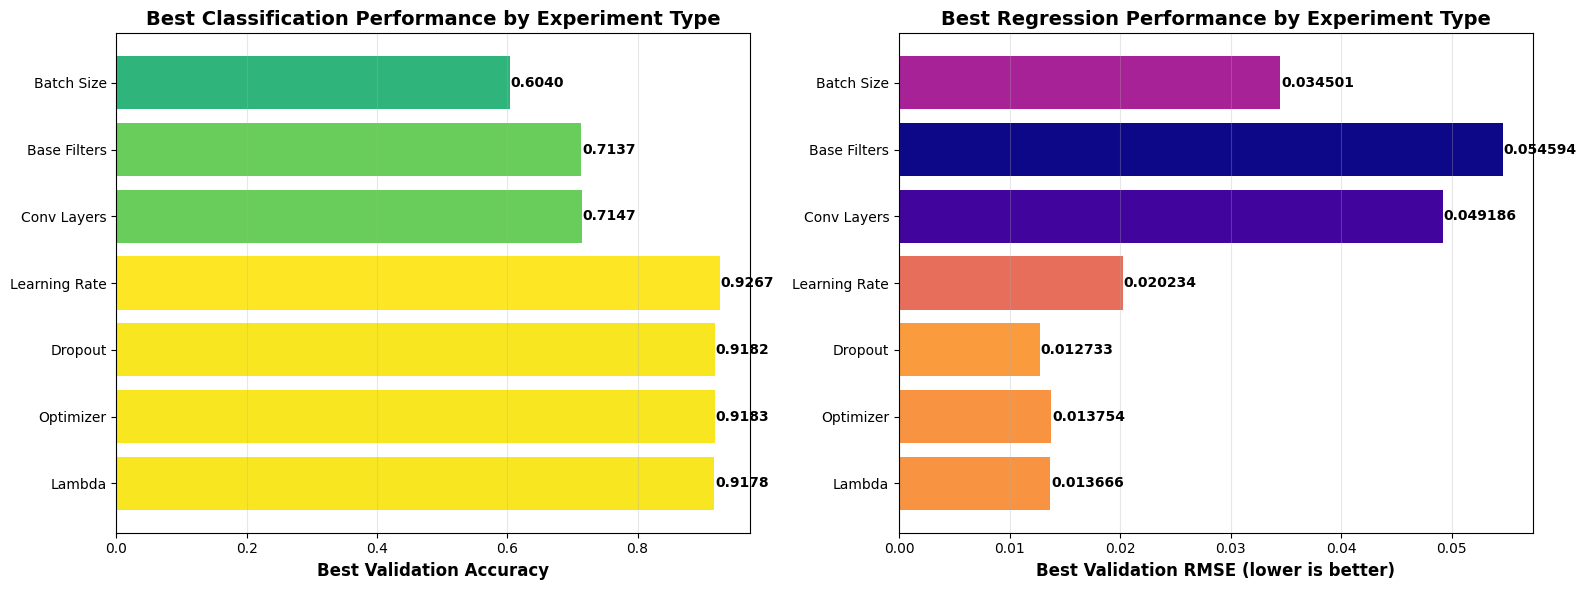

🔍 Searching across all experiments for best models...

✓ Loaded 8 runs from Lambda
✓ Loaded 3 runs from Optimizer
✓ Loaded 6 runs from Dropout
✓ Loaded 5 runs from Learning Rate
✓ Loaded 2 runs from Conv Layers
✓ Loaded 4 runs from Base Filters
✓ Loaded 4 runs from Batch Size

 Total runs analyzed: 32

 MODEL WITH HIGHEST VALIDATION ACCURACY:
Run Name: LR_Run3_0.001
Experiment Group: Learning Rate
Best Validation Accuracy: 0.926667

 Configuration:
  lambda1: 1.0
  lambda2: 1.0
  optimizer: Adam
  learning_rate: 0.001
  dropout_rate: 0.3
  num_blocks: 3
  base_filters: 32
  batch_size: 64
  class_hidden_dim: 128
  reg_hidden_dim: 128

 Other Metrics:
  best_val_rmse: 0.020234
  val_accuracy: 0.921833


 MODEL WITH LOWEST VALIDATION RMSE:
Run Name: Run8_L_1_1000
Experiment Group: Lambda
Best Validation RMSE: 0.006588

 Configuration:
  lambda1: 1.0
  lambda2: 1000.0
  optimizer: Adam
  learning_rate: 0.0001
  dropout_rate: 0.3
  num_blocks: 3
  base_filters: 32
  batch_size: 64
  class_

In [43]:
experiment_projects = {
    'Lambda': 'smai-a4-q1-lambda-experiments',
    'Optimizer': 'smai-a4-q1-optimizer-experiments',
    'Dropout': 'smai-a4-q1-dropout-experiments',
    'Learning Rate': 'smai-a4-q1-lr-experiments',
    'Conv Layers': 'smai-a4-q1-conv-experiments',
    'Base Filters': 'smai-a4-q1-base-filters-experiments',
    'Batch Size': 'smai-a4-q1-batch-size-experiments',
}

analyzer = WandBAnalyzer(experiment_projects)
analyzer.run_full_analysis()

In [17]:
config_best_acc = {
    "lambda1": 1.0, "lambda2": 1.0, "optimizer": "Adam", "learning_rate": 0.001,
    "dropout_rate": 0.3, "num_blocks": 3, "base_filters": 32, "batch_size": 64,
    "class_hidden_dim": 128, "reg_hidden_dim": 128,
    'conv_kernel_size': 3, 'pool_kernel_size': 2, 'pool_stride': 2 
}

config_best_rmse = {
    "lambda1": 1.0, "lambda2": 1000.0, "optimizer": "Adam", "learning_rate": 0.0001,
    "dropout_rate": 0.3, "num_blocks": 3, "base_filters": 32, "batch_size": 64,
    "class_hidden_dim": 128, "reg_hidden_dim": 128,
    'conv_kernel_size': 3, 'pool_kernel_size': 2, 'pool_stride': 2
}

def evaluate_on_test_set(model, test_loader, device="cuda"):
    model.eval()
    all_preds_class, all_labels_class = [], []
    all_preds_reg, all_labels_reg = [], []

    with torch.no_grad():
        for images, labels, inks in test_loader:
            images, labels, inks = images.to(device), labels.to(device), inks.to(device).float().squeeze()
            logits_class, value_ink = model(images)
            value_ink = value_ink.squeeze()
            all_preds_class.append(logits_class.cpu())
            all_labels_class.append(labels.cpu())
            all_preds_reg.append(value_ink.cpu())
            all_labels_reg.append(inks.cpu())

    all_preds_class = torch.cat(all_preds_class)
    all_labels_class = torch.cat(all_labels_class)
    all_preds_reg = torch.cat(all_preds_reg)
    all_labels_reg = torch.cat(all_labels_reg)
    test_acc = ExperimentManager._calculate_accuracy(all_preds_class, all_labels_class)
    test_mae = ExperimentManager._calculate_mae(all_preds_reg, all_labels_reg)
    test_rmse = ExperimentManager._calculate_rmse(all_preds_reg, all_labels_reg)
    return test_acc, test_mae, test_rmse

device = "cuda" if torch.cuda.is_available() else "cpu"
_, _, test_loader = load_fashion_data(batch_size=64)
model_acc = MultiTaskCNN(**(ExperimentManager._filter_config_for_model(config_best_acc))).to(device)
model_acc.load_state_dict(torch.load("models/best_acc_LR_Run3_0.001.pth", map_location=device))
model_rmse = MultiTaskCNN(**(ExperimentManager._filter_config_for_model(config_best_rmse))).to(device)
model_rmse.load_state_dict(torch.load("models/best_rmse_Run8_L_1_1000.pth", map_location=device))
print("Evaluating Best Accuracy Model on Test Set...")
acc_test_acc, acc_test_mae, acc_test_rmse = evaluate_on_test_set(model_acc, test_loader, device)

print("Evaluating Best RMSE Model on Test Set...")
rmse_test_acc, rmse_test_mae, rmse_test_rmse = evaluate_on_test_set(model_rmse, test_loader, device)

print("\n--- FINAL TEST METRICS ---")
print(f"Best Acc Model: \tTest Acc: {acc_test_acc:.4f}, \tTest MAE: {acc_test_mae:.4f}, \tTest RMSE: {acc_test_rmse:.4f}")
print(f"Best RMSE Model: \tTest Acc: {rmse_test_acc:.4f}, \tTest MAE: {rmse_test_mae:.4f}, \tTest RMSE: {rmse_test_rmse:.4f}")

Evaluating Best Accuracy Model on Test Set...
Evaluating Best RMSE Model on Test Set...

--- FINAL TEST METRICS ---
Best Acc Model: 	Test Acc: 0.9213, 	Test MAE: 0.0228, 	Test RMSE: 0.0292
Best RMSE Model: 	Test Acc: 0.8949, 	Test MAE: 0.0051, 	Test RMSE: 0.0067


ExperimentManager initialized. Using device: cuda
--- Starting all wandb Experiments ---

--- Starting Run: Baseline ---


Epoch 30 Val: 100%|██████████| 94/94 [00:00<00:00, 163.53it/s]

Finished run: Baseline


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█████
train_loss_ce,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_total,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▅▆▆▆▆▇▇▇▇▇▇▇▆▇█▇█▇██▇█▇██
val_loss_ce,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▂▁▂▁▁
val_loss_mse,█▃▃▃▅▂▂▂▂▃▁▁▂▁▂▃▂▂▁▁▂▁▁▁▂▁▁▁▁▁
val_loss_total,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▂▁▂▁▁
val_mae,█▅▄▄▆▃▄▂▂▃▂▁▃▂▂▄▂▃▁▂▃▂▂▂▃▁▁▂▂▁
val_rmse,█▄▄▄▅▃▃▂▂▃▁▁▃▂▂▄▂▃▁▂▃▂▂▁▂▁▁▁▂▁
best_val_accuracy,0.92817



--- All experiments completed. ---

--- Starting Feature Map Visualization for 'Baseline' ---
Visualizing feature maps for 3 images...


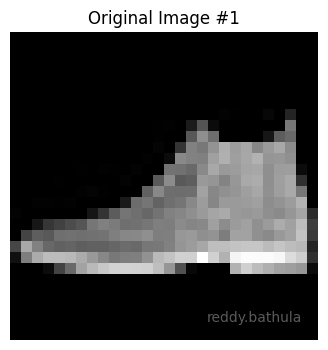

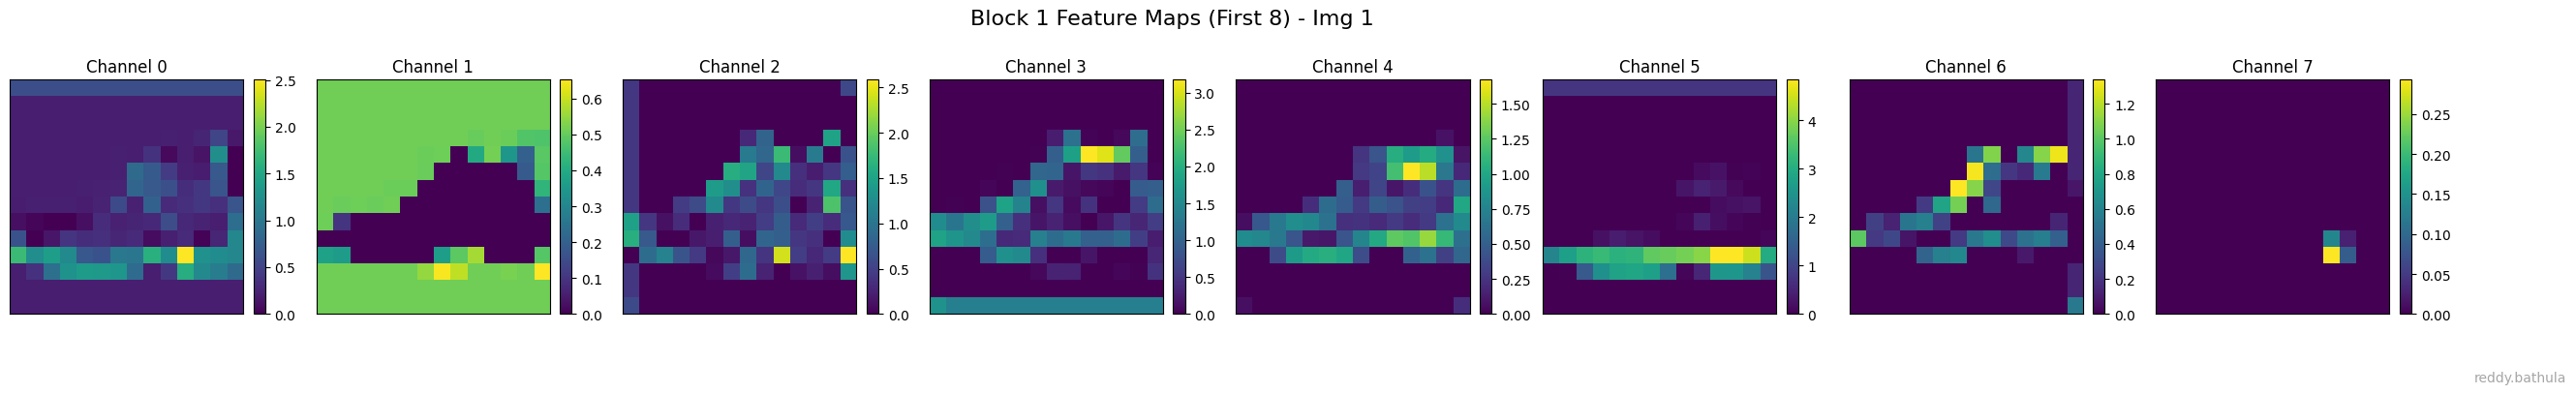

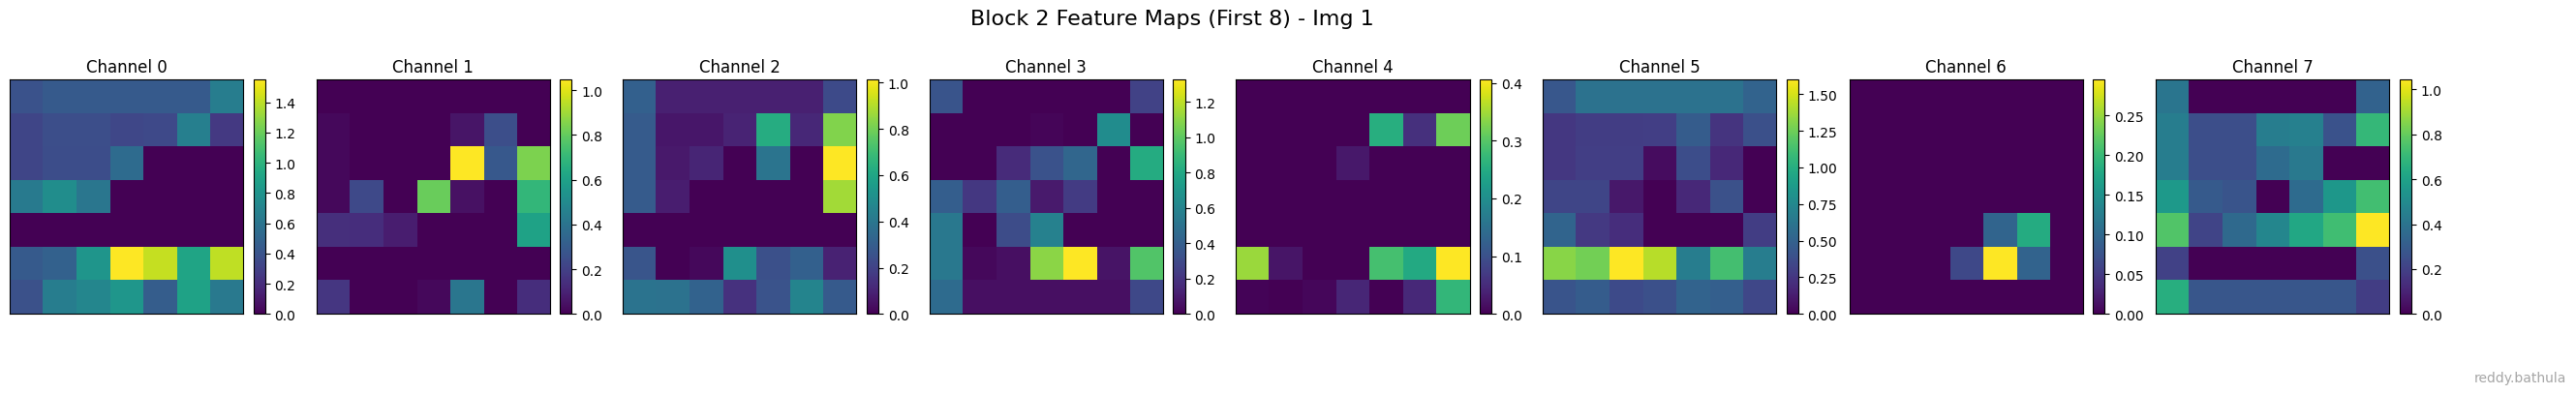

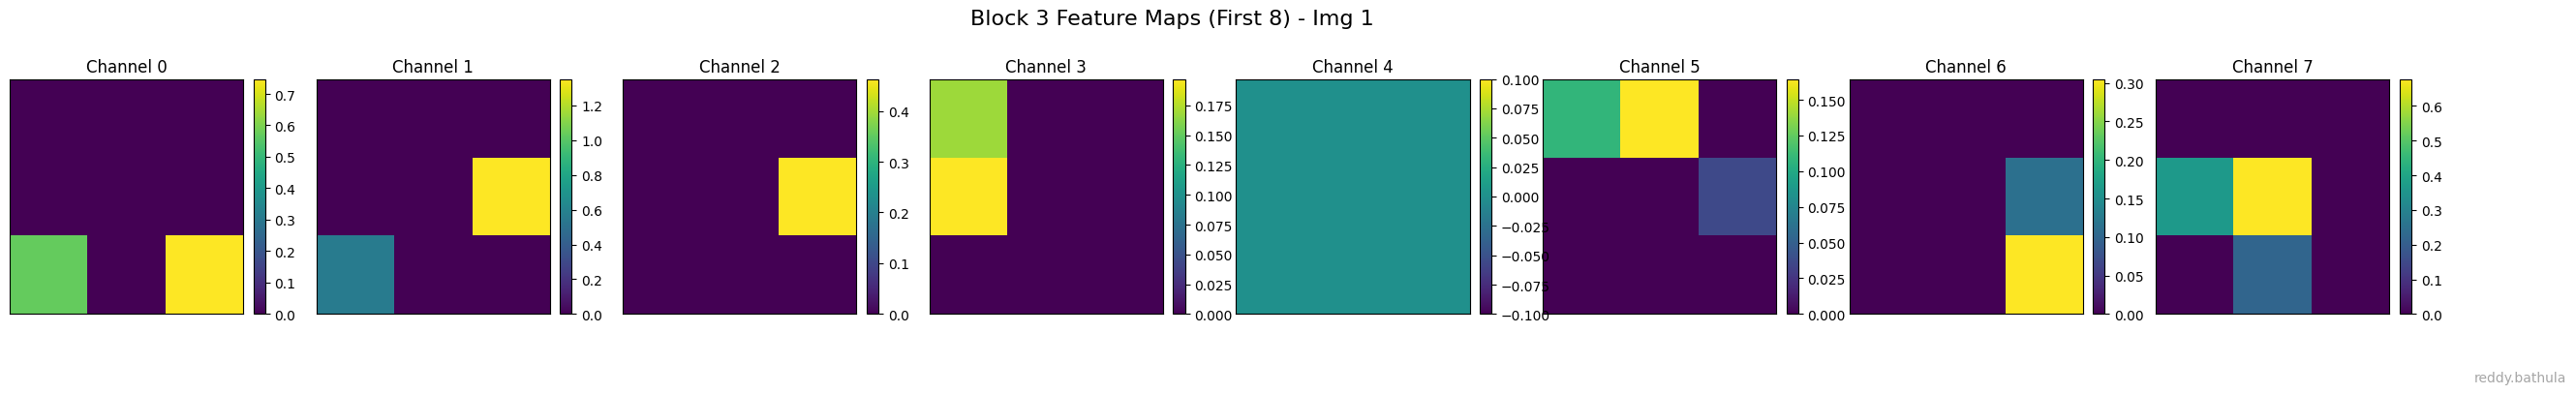

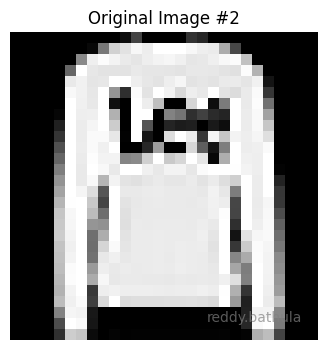

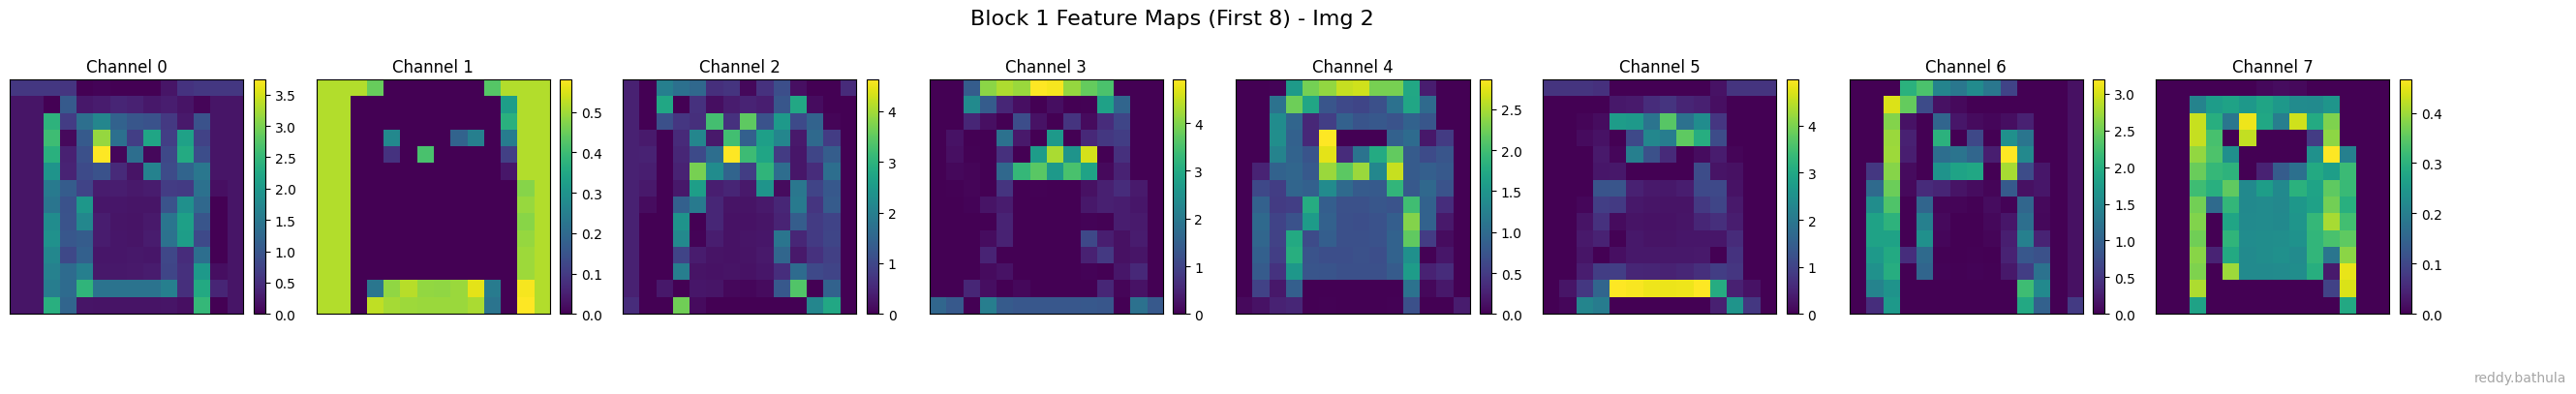

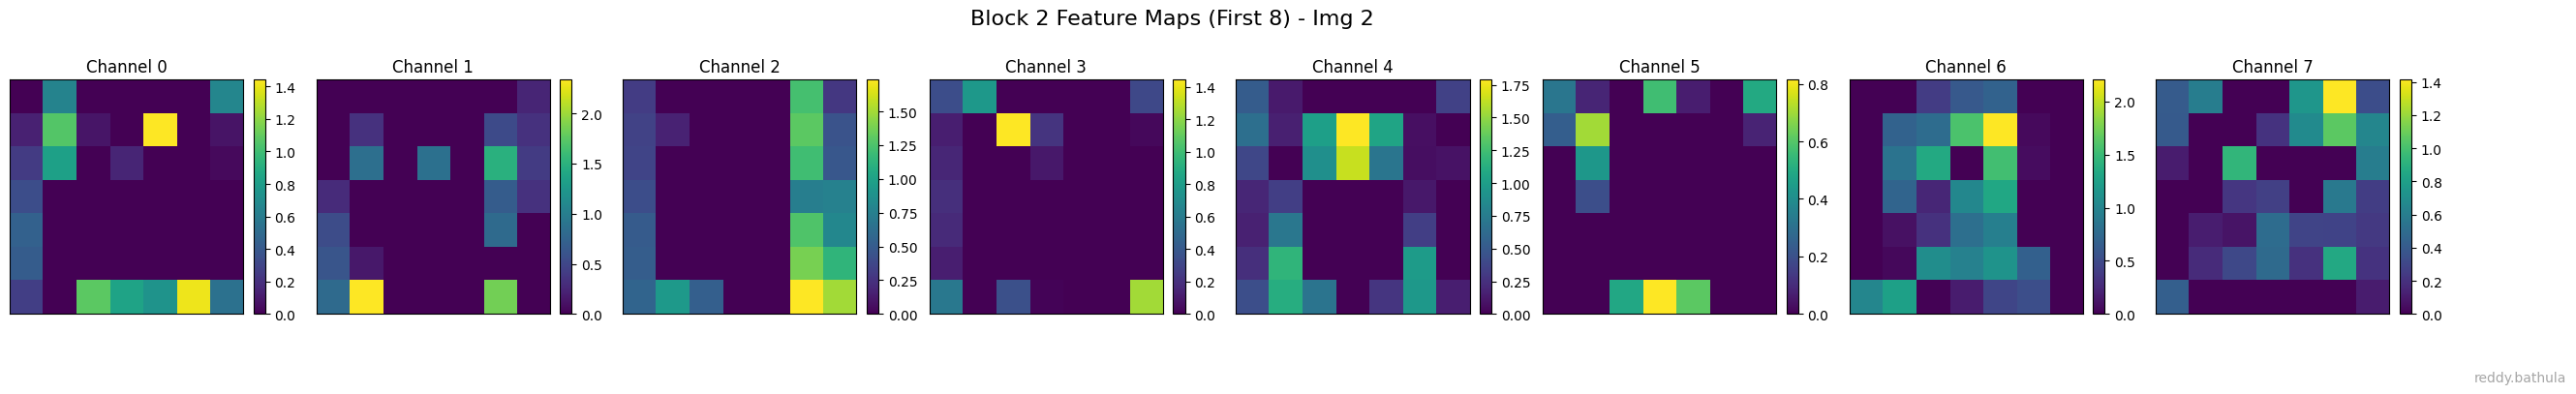

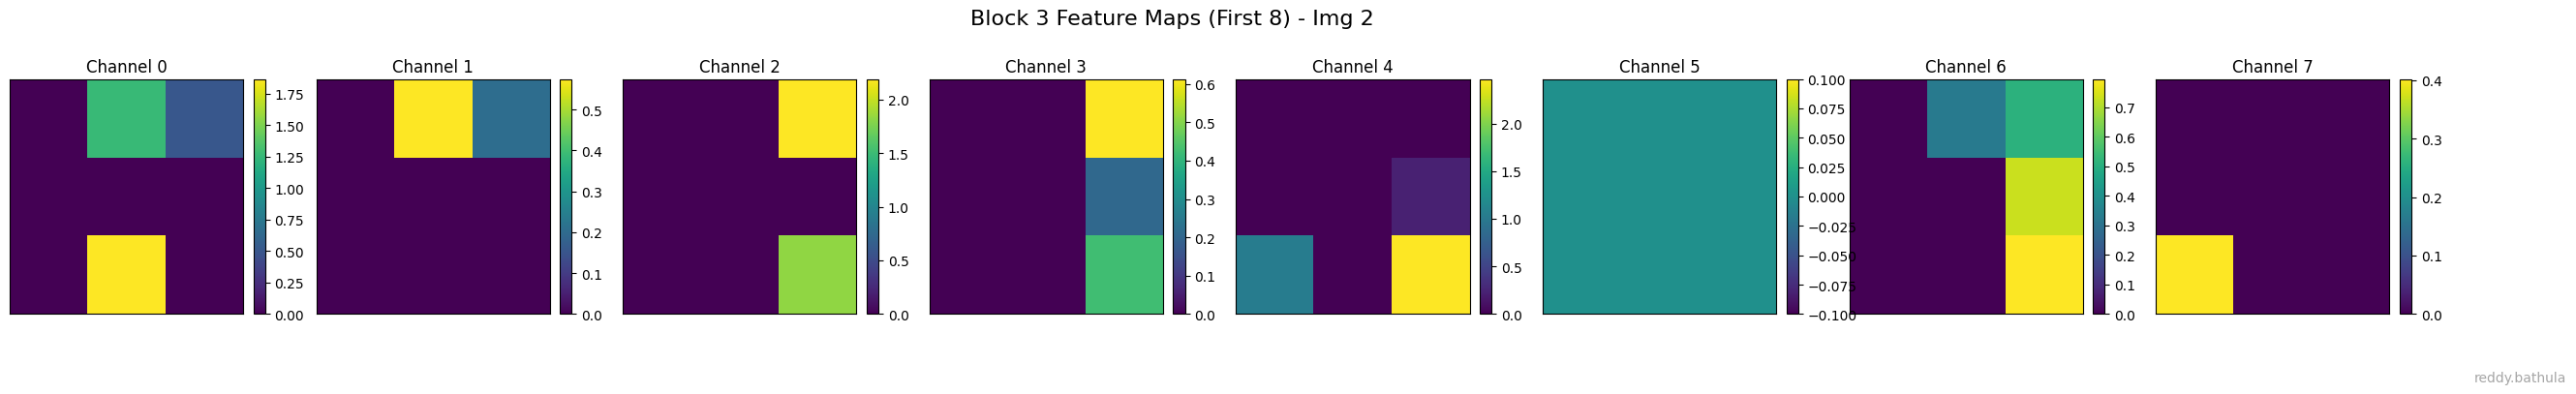

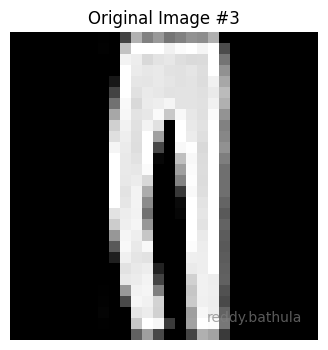

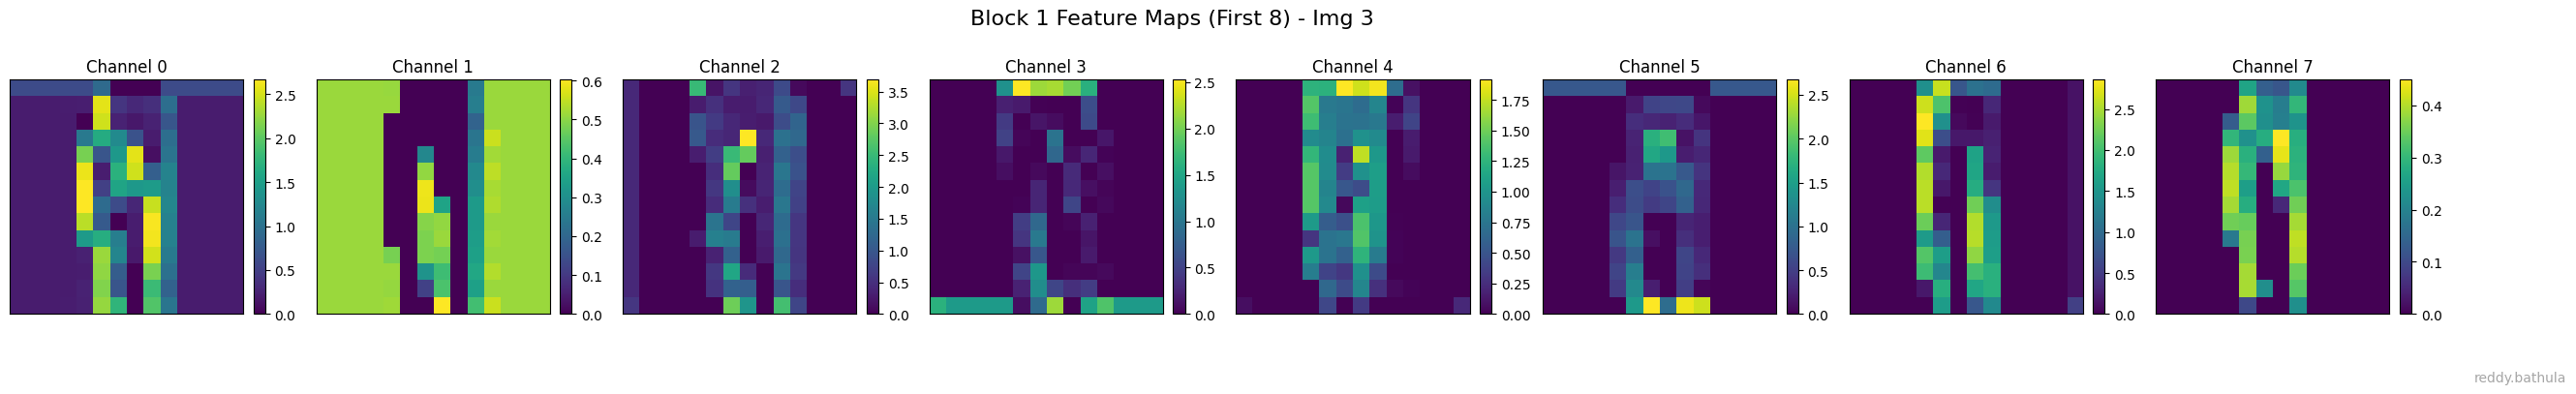

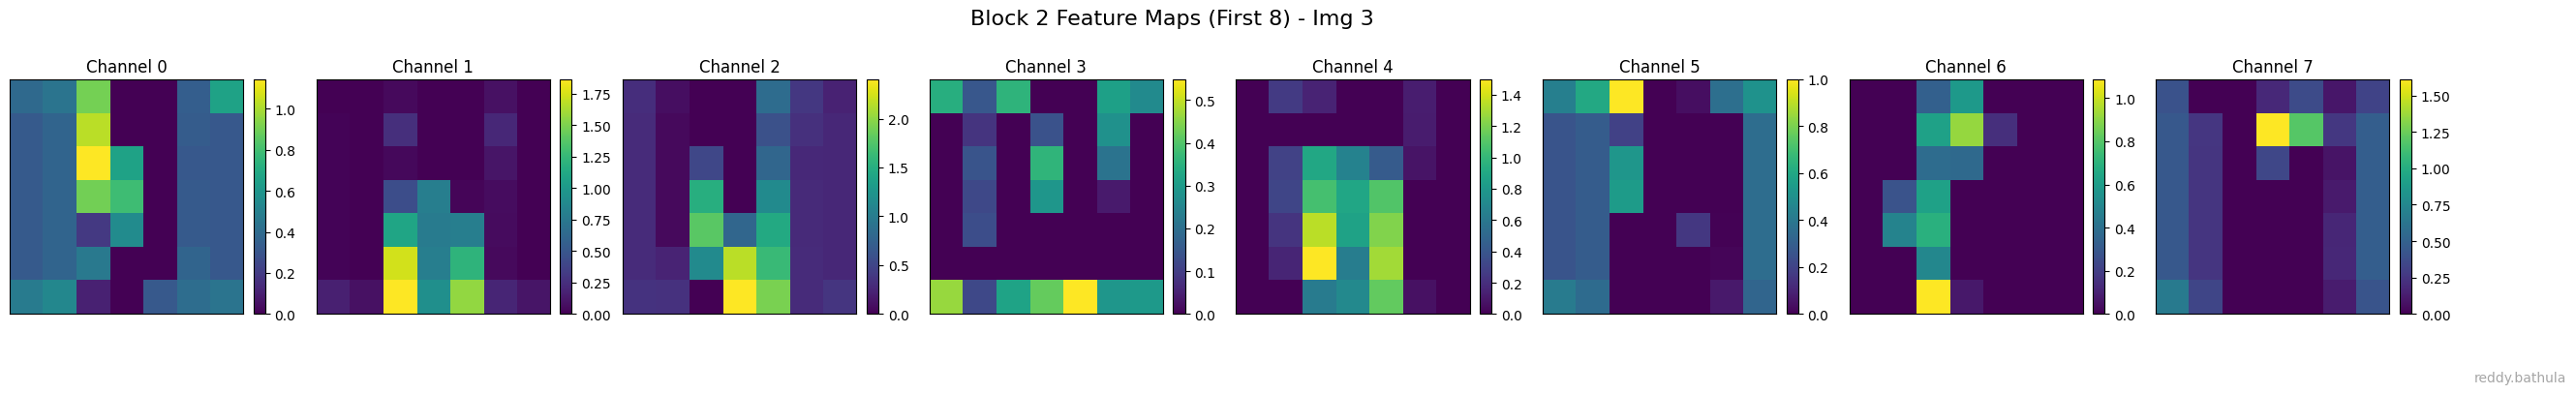

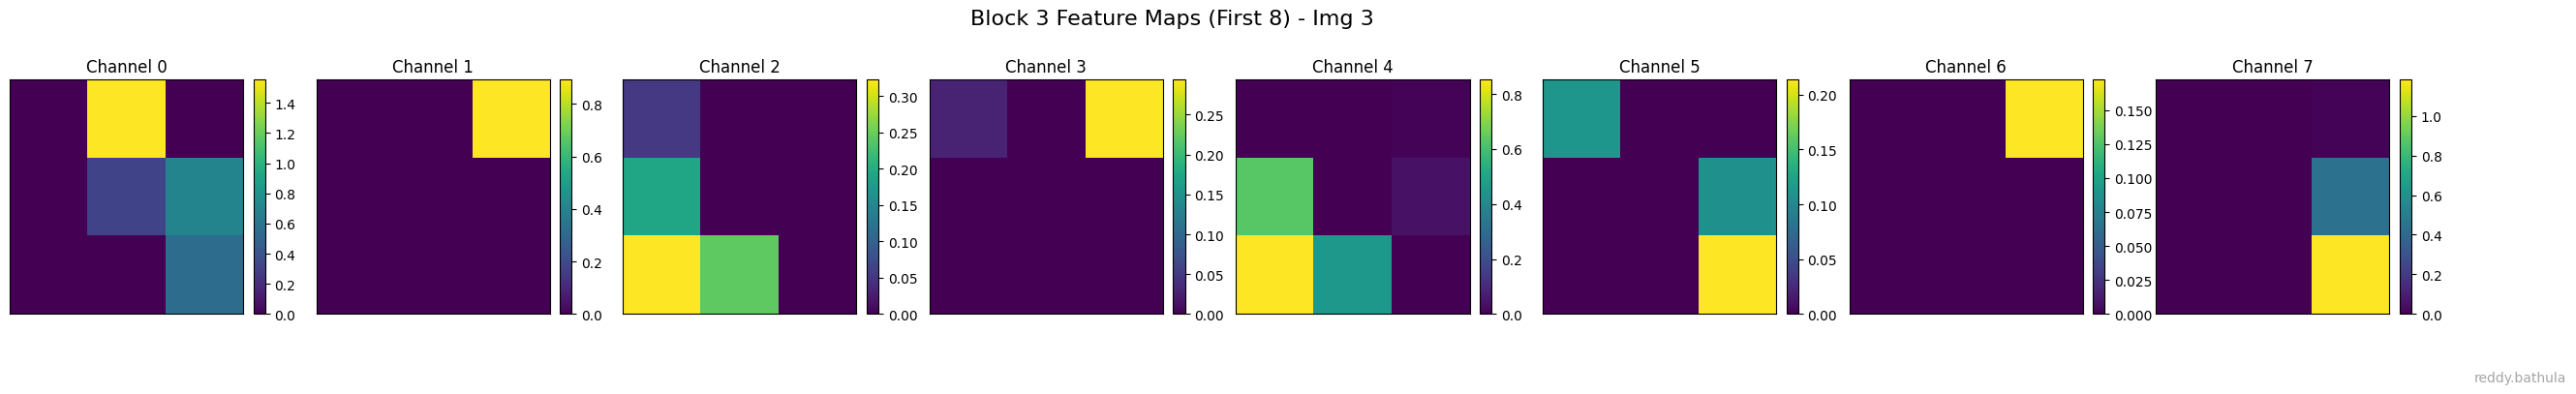

In [15]:
# Baseline_run
experiments = {
    "Baseline": {
        "num_blocks": 3,
        "base_filters": 32,
        "class_hidden_dim": 128,
        "reg_hidden_dim": 128,
        "dropout_rate": 0.3,
        "conv_kernel_size": 3,
        "pool_kernel_size": 2,
        "pool_stride": 2,
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "batch_size": 64,
        "epochs": 30,
        "lambda1": 1.0,
        "lambda2": 1.0
    }
}

manager = ExperimentManager(experiments_dict=experiments, 
                            email_username=EMAIL_USERNAME,
                            wandb_project="smai-a4-q1-baseline")

manager.run_all_experiments()
manager.visualize_model(run_name="Baseline")